In [1]:
%%capture
!pip install numpy pandas matplotlib tensorflow keras torch scipy

# Stage 1: Data Preparation and Preprocessing

**Dataset:** Fashion-MNIST (70,000 samples, 10 classes, 28x28 grayscale images)

**Data Splitting:**
- Test set: 10% — Validation set: 10% — Training pool: 80%

**Semi-Supervised Setup** (from training pool):
- 10% labeled (labels available) — 90% unlabeled (labels hidden)

**Preprocessing Pipeline** (when `preprocess=True`):
1. Split raw data first (no leakage)
2. Compute normalization stats from **labeled train only**
3. Apply Z-score normalization to all splits
4. Augment **train only**: 50% horizontal flip + 50% 3x3 color jitter

Data Loaded. Shape: (70000, 785)
PREPROCESSING COMPARISON

Raw (0-255):
  Mean:  72.9698
  Std:   70.0766
  Min:   0.0000
  Max:   255.0000

Z-Score:
  Mean:  -0.0000
  Std:   1.0000
  Min:   -2.4116
  Max:   194.0902

Min-Max:
  Mean:  0.2862
  Std:   0.2750
  Min:   0.0000
  Max:   1.0000

SEMI-SUPERVISED SPLIT (with preprocessing + augmentation)
  Labeled train:   22,400 (includes augmented)
  Unlabeled train: 44,800
  Validation:      7,000
  Test:            7,000

Class distribution (original labeled train, before aug):


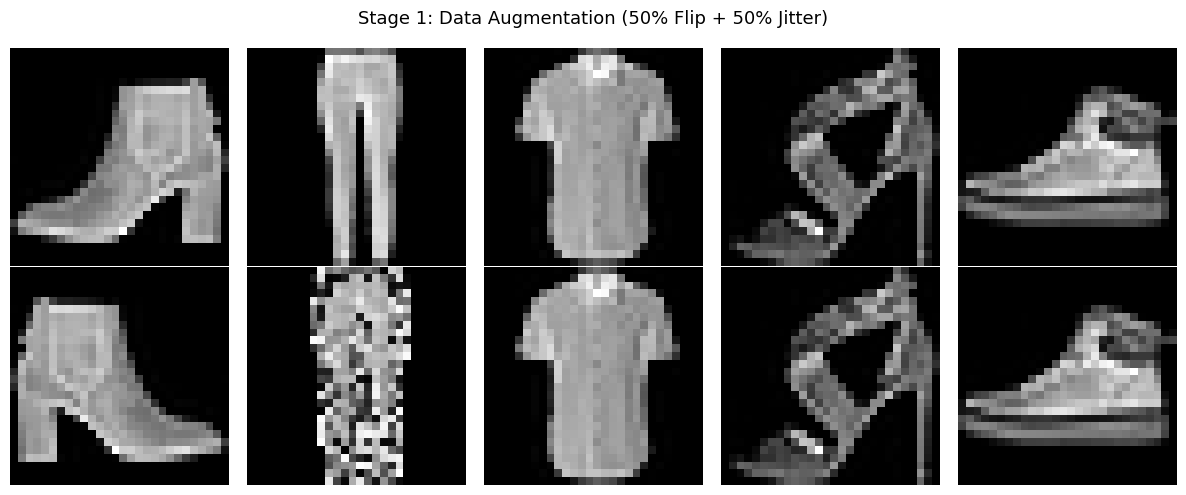

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataLoader import DataLoader

loader = DataLoader()

# ---------------------------------------------------------
# 1a. Preprocessing Comparison: Z-Score vs Min-Max
# ---------------------------------------------------------
df_zscore = loader.get_z_score_df()
df_minmax = loader.get_min_max_df()
df_raw = loader.get_standard_df()

print("=" * 60)
print("PREPROCESSING COMPARISON")
print("=" * 60)

for name, df in [("Raw (0-255)", df_raw), ("Z-Score", df_zscore), ("Min-Max", df_minmax)]:
    features = df[loader.feature_cols]
    print(f"\n{name}:")
    print(f"  Mean:  {features.mean().mean():.4f}")
    print(f"  Std:   {features.std().mean():.4f}")
    print(f"  Min:   {features.min().min():.4f}")
    print(f"  Max:   {features.max().max():.4f}")

# ---------------------------------------------------------
# 1b. Data Splitting with proper pipeline (preprocess=True)
# ---------------------------------------------------------
data_dict = loader.prepare_data(
    test_size=0.10, val_size=0.10, labeled_ratio=0.20, seed=1,
    preprocess=True, normalize="z_score"
)

print(f"\n{'=' * 60}")
print(f"SEMI-SUPERVISED SPLIT (with preprocessing + augmentation)")
print(f"{'=' * 60}")
print(f"  Labeled train:   {len(data_dict['labeled_train']):,} (includes augmented)")
print(f"  Unlabeled train: {len(data_dict['unlabeled_train']):,}")
print(f"  Validation:      {len(data_dict['validation']):,}")
print(f"  Test:            {len(data_dict['test']):,}")

# ---------------------------------------------------------
# 1c. Class Distribution
# ---------------------------------------------------------
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Note: labeled_train now has 2x samples due to augmentation
original_count = len(data_dict['labeled_train']) // 2
print(f"\nClass distribution (original labeled train, before aug):")

# ---------------------------------------------------------
# 1d. Augmentation Demo (50% flip + 50% jitter)
# ---------------------------------------------------------
raw_data = loader.prepare_data(
    test_size=0.10, val_size=0.10, labeled_ratio=0.20, seed=1,
    preprocess=False  # Get raw for demo
)
sample = raw_data['labeled_train'].head(5)
augmented = loader.augment_combined(sample, flip_prob=0.5, jitter_prob=0.5)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(5):
    orig_img = sample.iloc[i][loader.feature_cols].values.reshape(28, 28)
    aug_img = augmented.iloc[i][loader.feature_cols].values.reshape(28, 28)
    axes[0][i].imshow(orig_img, cmap='gray'); axes[0][i].axis('off')
    axes[1][i].imshow(aug_img, cmap='gray'); axes[1][i].axis('off')
    if i == 0:
        axes[0][i].set_ylabel('Original')
        axes[1][i].set_ylabel('Augmented')

plt.suptitle('Stage 1: Data Augmentation (50% Flip + 50% Jitter)', fontsize=13)
plt.tight_layout()
plt.show()

# Stage 2: Supervised Neural Network Baseline

**Architecture:** 784 → 1028 (ReLU) → 1028 (ReLU) → 10 (Softmax via CrossEntropyLoss)

**Training:** SGD with mini-batch (batch=64), learning rate=0.01, momentum=0.04

**Ablation Configurations** (each with 5 seeds for statistical rigor):

| Config | Preprocess | Init | Model |
|--------|-----------|------|-------|
| `baseline` | No (raw) | normal | VanillaModel |
| `+preprocessing` | Yes (Z-score + aug) | normal | VanillaModel |
| `+he_init` | Yes | He | VanillaModel |

**Note:** Preprocessing  includes normalization (train stats only) + augmentation (50% flip + 50% jitter on train only).

## Overfitting Detection

**Criterion:** $E_V^{(t)} > \bar{E}_V + k \cdot \sigma_{E_V} \cdot \sqrt{t_0 / t}$

In [3]:
import torch
import numpy as np
from DataLoader import DataLoader
from VanillaModel import VanillaModel
from Overfitting import OverfitDetector
from Results import Results

# ---------------------------------------------------------
# Seed-setting utility
# ---------------------------------------------------------
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ---------------------------------------------------------
# Results pipeline
# ---------------------------------------------------------
results = Results(base_dir="results")

# ---------------------------------------------------------
# Ablation configurations (simplified: preprocess = norm + aug)
# ---------------------------------------------------------
ABLATION_CONFIGS = [
    {"config": "baseline",       "preprocess": False, "init": "normal"},
    {"config": "+preprocessing", "preprocess": True,  "init": "normal"},
    {"config": "+he_init",       "preprocess": True,  "init": "he"},
]

EPOCHS = 200
LR = 0.01
MOMENTUM = 0.5
SEEDS = [1, 42, 123, 456, 12345]

# ---------------------------------------------------------
# Generic training function
# ---------------------------------------------------------
def run_ablation(cfg, seed):
    set_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    loader = DataLoader()

    # prepare_data handles: split -> normalize (train stats) -> augment (train only)
    data_dict = loader.prepare_data(
        test_size=0.10, val_size=0.10, labeled_ratio=0.20, seed=seed,
        preprocess=cfg["preprocess"], normalize="z_score"
    )

    loaders = loader.to_torch_loaders({
        "train": data_dict["labeled_train"],
        "validation": data_dict["validation"],
        "test": data_dict["test"]
    }, batch_size=64)

    # Determine tags for logging
    norm_tag = "z_score" if cfg["preprocess"] else "raw"
    aug_tag = "flip+jitter" if cfg["preprocess"] else "none"

    results.begin_run(
        seed=seed, weight_init=cfg["init"], normalization=norm_tag,
        augmentations=aug_tag, config=cfg["config"], lr=LR, momentum=MOMENTUM
    )

    set_seed(seed)
    model = VanillaModel(init_strategy=cfg["init"], lr=LR, momentum=MOMENTUM).to(device)

    overfit_detector = OverfitDetector(max_epochs=EPOCHS)
    converged_epoch = EPOCHS

    for epoch in range(EPOCHS):
        train_loss, train_acc = model.train_epoch(loaders["train"], device)
        val_loss, val_acc = model.evaluate(loaders["validation"], device)
        results.log_epoch(epoch + 1, train_loss, train_acc, val_loss, val_acc)

        val_error = 1.0 - val_acc
        is_overfitting, mean_ev, std_ev = overfit_detector.check(val_error, epoch + 1)

        if (epoch + 1) % 20 == 0:
            status = " ** OVERFIT **" if is_overfitting else ""
            print(f"      Epoch {epoch+1:03d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}{status}")

        if is_overfitting:
            converged_epoch = epoch + 1
            print(f"      >>> Overfitting at epoch {converged_epoch}")
            break

    _, test_acc = model.evaluate(loaders["test"], device)
    results.end_run(test_acc=test_acc, converged_epoch=converged_epoch)
    return test_acc, converged_epoch

# ---------------------------------------------------------
# Run all configs x seeds
# ---------------------------------------------------------
for cfg in ABLATION_CONFIGS:
    print(f"\n{'='*60}")
    print(f"Config: {cfg['config']}")
    print(f"{'='*60}")
    for seed in SEEDS:
        print(f"   Seed {seed}...")
        acc, ep = run_ablation(cfg, seed)
        print(f"   -> Test Acc: {acc:.4f} | Epochs: {ep}")

# ---------------------------------------------------------
# Summary
# ---------------------------------------------------------
print(f"\n{'='*60}")
print(f"STAGE 2 ABLATION SUMMARY")
print(f"{'='*60}")
results.summary()


Config: baseline
   Seed 1...
Data Loaded. Shape: (70000, 785)
      Epoch 020 | Train Acc: 0.1003 | Val Acc: 0.0984
      Epoch 040 | Train Acc: 0.1003 | Val Acc: 0.0984
      Epoch 060 | Train Acc: 0.1003 | Val Acc: 0.0984
      Epoch 080 | Train Acc: 0.1003 | Val Acc: 0.0984
      Epoch 100 | Train Acc: 0.1003 | Val Acc: 0.0984
      Epoch 120 | Train Acc: 0.1003 | Val Acc: 0.0984
      Epoch 140 | Train Acc: 0.1003 | Val Acc: 0.0984
      >>> Overfitting at epoch 159
   -> Test Acc: 0.0991 | Epochs: 159
   Seed 42...
Data Loaded. Shape: (70000, 785)
      Epoch 020 | Train Acc: 0.0999 | Val Acc: 0.1040
      Epoch 040 | Train Acc: 0.0999 | Val Acc: 0.1040
      Epoch 060 | Train Acc: 0.0999 | Val Acc: 0.1040
      Epoch 080 | Train Acc: 0.0999 | Val Acc: 0.1040
      Epoch 100 | Train Acc: 0.0999 | Val Acc: 0.1040
      Epoch 120 | Train Acc: 0.0999 | Val Acc: 0.1040
      Epoch 140 | Train Acc: 0.0999 | Val Acc: 0.1040
      Epoch 160 | Train Acc: 0.0999 | Val Acc: 0.1040
      E

# Stage 3: Architecture Selection and Regularization

Two techniques implemented:
1. **L1 Regularization** — encourages sparsity in weights
2. **Magnitude-Based Pruning** — train oversized network, prune smallest weights, fine-tune

Both use Stage2Model with the loss function:
$$\mathcal{L}(w) = \mathcal{L}_{CE} + \lambda_1 |w|$$

**RigL** (Evci et al., 2020) is an advancement on pruning: sparse-to-sparse training with topology updates.

## Stage 3a: L1 Regularization

Adds L1 regularization to the baseline pipeline. Uses Stage2Model with hidden_size=1028 (same as baseline) and no pruning — isolating the effect of regularization.

In [2]:
import torch
import numpy as np
from DataLoader import DataLoader
from Stage2Model import Stage2Model
from Overfitting import OverfitDetector
from Results import Results

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

results = Results(base_dir="results")

EPOCHS = 200
LR = 0.01
MOMENTUM = 0.04
SEEDS = [1, 42, 123, 456, 12345]
CONFIG_TAG = "+l1_reg"

def run_l1_reg(seed):
    set_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    loader = DataLoader()
    data_dict = loader.prepare_data(
        test_size=0.10, val_size=0.10, labeled_ratio=0.20, seed=seed,
        preprocess=True, normalize="z_score"
    )

    loaders = loader.to_torch_loaders({
        "train": data_dict["labeled_train"],
        "validation": data_dict["validation"],
        "test": data_dict["test"]
    }, batch_size=64)

    results.begin_run(
        seed=seed, weight_init="he", normalization="z_score",
        augmentations="flip+jitter", config=CONFIG_TAG, lr=LR, momentum=MOMENTUM
    )

    set_seed(seed)
    model = Stage2Model(
        hidden_size=1028, init_strategy="he", lr=LR, momentum=MOMENTUM,
        lambda1=1e-4
    ).to(device)

    overfit_detector = OverfitDetector(max_epochs=EPOCHS)
    converged_epoch = EPOCHS

    for epoch in range(EPOCHS):
        train_loss, train_acc = model.train_epoch(loaders["train"], device)
        val_loss, val_acc = model.evaluate(loaders["validation"], device)
        results.log_epoch(epoch + 1, train_loss, train_acc, val_loss, val_acc)

        val_error = 1.0 - val_acc
        is_overfitting, mean_ev, std_ev = overfit_detector.check(val_error, epoch + 1)

        if (epoch + 1) % 20 == 0:
            status = " ** OVERFIT **" if is_overfitting else ""
            print(f"      Epoch {epoch+1:03d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}{status}")

        if is_overfitting:
            converged_epoch = epoch + 1
            print(f"      >>> Overfitting at epoch {converged_epoch}")
            break

    _, test_acc = model.evaluate(loaders["test"], device)
    results.end_run(test_acc=test_acc, converged_epoch=converged_epoch)
    return test_acc, converged_epoch

# ---------------------------------------------------------
# Run 5 seeds
# ---------------------------------------------------------
print(f"{'='*60}")
print(f"Config: {CONFIG_TAG} (Stage2Model hidden=1028, L1 reg)")
print(f"{'='*60}")
for seed in SEEDS:
    print(f"   Seed {seed}...")
    acc, ep = run_l1_reg(seed)
    print(f"   -> Test Acc: {acc:.4f} | Epochs: {ep}")

results.summary()

Config: +l1_reg (Stage2Model hidden=1028, L1 reg)
   Seed 1...
Data Loaded. Shape: (70000, 785)
      Epoch 020 | Train Acc: 0.9747 | Val Acc: 0.8659
      >>> Overfitting at epoch 25
   -> Test Acc: 0.8663 | Epochs: 25
   Seed 42...
Data Loaded. Shape: (70000, 785)
      >>> Overfitting at epoch 17
   -> Test Acc: 0.8634 | Epochs: 17
   Seed 123...
Data Loaded. Shape: (70000, 785)
      Epoch 020 | Train Acc: 0.9758 | Val Acc: 0.8731
      >>> Overfitting at epoch 24
   -> Test Acc: 0.8754 | Epochs: 24
   Seed 456...
Data Loaded. Shape: (70000, 785)
      >>> Overfitting at epoch 17
   -> Test Acc: 0.8580 | Epochs: 17
   Seed 12345...
Data Loaded. Shape: (70000, 785)
      Epoch 020 | Train Acc: 0.9745 | Val Acc: 0.8590
      >>> Overfitting at epoch 36
   -> Test Acc: 0.8703 | Epochs: 36
               +l1_reg | Test Acc: 0.8667 +/- 0.0059 | Epochs: 23.8 +/- 7.0 | n=5


## Stage 3a continued: Magnitude-Based Pruning

Adds pruning on top of L1 regularization. Uses Stage2Model with:
- **2x wider** network (hidden_size=2056)
- L1 regularization during pre-training
- Global magnitude pruning at **{10%, 25%, 50%}** rates
- Fine-tuning after pruning

The ablation table uses the **best pruning rate** (25%) as the representative config.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from DataLoader import DataLoader
from Stage2Model import Stage2Model
from Overfitting import OverfitDetector
from Results import Results

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

results = Results(base_dir="results")

PRETRAIN_EPOCHS = 200
FINETUNE_EPOCHS = 50
LR = 0.01
MOMENTUM = 0.04
PRUNE_RATES = [0.10, 0.25, 0.50]
SEEDS = [1, 42, 123, 456, 12345]

def run_pruning(seed, prune_rate):
    set_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    loader = DataLoader()
    data_dict = loader.prepare_data(
        test_size=0.10, val_size=0.10, labeled_ratio=0.20, seed=seed,
        preprocess=True, normalize="z_score"
    )

    loaders = loader.to_torch_loaders({
        "train": data_dict["labeled_train"],
        "validation": data_dict["validation"],
        "test": data_dict["test"]
    }, batch_size=64)

    config_tag = f"+pruning_{int(prune_rate*100)}pct"

    # --- Phase 1: Pre-train ---
    results.begin_run(
        seed=seed, weight_init="he", normalization="z_score",
        augmentations="flip+jitter", config=f"{config_tag}_pretrain",
        lr=LR, momentum=MOMENTUM
    )

    set_seed(seed)
    model = Stage2Model(hidden_size=2056, init_strategy="he",
                        lr=LR, momentum=MOMENTUM, lambda1=1e-4).to(device)

    overfit_detector = OverfitDetector(max_epochs=PRETRAIN_EPOCHS)
    pretrain_converged = PRETRAIN_EPOCHS

    for epoch in range(PRETRAIN_EPOCHS):
        train_loss, train_acc = model.train_epoch(loaders["train"], device)
        val_loss, val_acc = model.evaluate(loaders["validation"], device)
        results.log_epoch(epoch + 1, train_loss, train_acc, val_loss, val_acc)

        val_error = 1.0 - val_acc
        is_overfitting, mean_ev, std_ev = overfit_detector.check(val_error, epoch + 1)

        if (epoch + 1) % 20 == 0:
            status = " ** OVERFIT **" if is_overfitting else ""
            print(f"      Epoch {epoch+1:03d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}{status}")

        if is_overfitting:
            pretrain_converged = epoch + 1
            print(f"      >>> Stopped at epoch {pretrain_converged} (overfitting)")
            break

    if pretrain_converged == PRETRAIN_EPOCHS:
        print(f"      >>> Completed {PRETRAIN_EPOCHS} epochs (no early stop)")

    _, pre_prune_test = model.evaluate(loaders["test"], device)
    results.end_run(test_acc=pre_prune_test, converged_epoch=pretrain_converged)

    # --- Phase 2: Prune ---
    model.prune(prune_rate)
    _, post_prune_test = model.evaluate(loaders["test"], device)
    print(f"      Post-prune ({prune_rate:.0%}): {post_prune_test:.4f} | Sparsity: {model.sparsity():.1%}")

    # --- Phase 3: Fine-tune ---
    results.begin_run(
        seed=seed, weight_init="he", normalization="z_score",
        augmentations="flip+jitter", config=config_tag, lr=LR, momentum=MOMENTUM
    )

    overfit_detector = OverfitDetector(max_epochs=FINETUNE_EPOCHS)
    finetune_converged = FINETUNE_EPOCHS

    for epoch in range(FINETUNE_EPOCHS):
        train_loss, train_acc = model.train_epoch(loaders["train"], device)
        val_loss, val_acc = model.evaluate(loaders["validation"], device)
        results.log_epoch(epoch + 1, train_loss, train_acc, val_loss, val_acc,
                          sparsity=model.sparsity())

        val_error = 1.0 - val_acc
        is_overfitting, mean_ev, std_ev = overfit_detector.check(val_error, epoch + 1)

        if is_overfitting:
            finetune_converged = epoch + 1
            print(f"      >>> Fine-tune stopped at epoch {finetune_converged}")
            break

    if finetune_converged == FINETUNE_EPOCHS:
        print(f"      >>> Fine-tune completed {FINETUNE_EPOCHS} epochs")

    _, final_test = model.evaluate(loaders["test"], device)
    results.end_run(test_acc=final_test, converged_epoch=finetune_converged)

    return {
        "seed": seed, "prune_rate": prune_rate,
        "pre_prune_acc": pre_prune_test,
        "post_prune_acc": post_prune_test,
        "final_acc": final_test,
    }

# ---------------------------------------------------------
# Run all combinations
# ---------------------------------------------------------
all_pruning_results = []

for prune_rate in PRUNE_RATES:
    print(f"\n{'='*60}")
    print(f"Pruning {prune_rate:.0%}")
    print(f"{'='*60}")
    for seed in SEEDS:
        print(f"   Seed {seed}...")
        r = run_pruning(seed, prune_rate)
        all_pruning_results.append(r)
        print(f"   -> Pre: {r['pre_prune_acc']:.4f} | Post: {r['post_prune_acc']:.4f} | Fine-tuned: {r['final_acc']:.4f}")

# ---------------------------------------------------------
# Summary
# ---------------------------------------------------------
print(f"\n{'='*70}")
print(f"PRUNING RESULTS SUMMARY")
print(f"{'='*70}")
for rate in PRUNE_RATES:
    group = [r for r in all_pruning_results if r["prune_rate"] == rate]
    fine = np.array([r["final_acc"] for r in group])
    print(f"  {rate:>5.0%} | Fine-tuned: {fine.mean():.4f} +/- {fine.std():.4f}")

# ---------------------------------------------------------
# Plot
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(PRUNE_RATES))
width = 0.25

for i, (label, key) in enumerate([
    ("Pre-Prune", "pre_prune_acc"),
    ("Post-Prune", "post_prune_acc"),
    ("Fine-Tuned", "final_acc")
]):
    means = [np.mean([r[key] for r in all_pruning_results if r["prune_rate"] == rate]) for rate in PRUNE_RATES]
    stds = [np.std([r[key] for r in all_pruning_results if r["prune_rate"] == rate]) for rate in PRUNE_RATES]
    ax.bar(x + i * width, means, width, yerr=stds, label=label, capsize=4)

ax.set_xlabel("Pruning Rate")
ax.set_ylabel("Test Accuracy")
ax.set_title("Stage 3a: Magnitude-Based Pruning (2x Hidden, L1 Regularization)")
ax.set_xticks(x + width)
ax.set_xticklabels([f"{int(r*100)}%" for r in PRUNE_RATES])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## Stage 3b: RigL Sparse-to-Sparse Training

**Approach (Evci et al., 2020):**
1. Start with **2x wider** network (hidden_size=2056) + L1 regularization
2. **Initial prune** to target sparsity using magnitude
3. **Topology updates** every 100 steps: drop smallest active weights, grow where gradients are largest
4. Total sparsity stays constant — only *which* weights are active changes
5. Compare sparsity targets: **{10%, 25%, 50%}**

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from DataLoader import DataLoader
from RigLModel import RigLModel
from Overfitting import OverfitDetector
from Results import Results

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

results = Results(base_dir="results")

EPOCHS = 200
LR = 0.01
MOMENTUM = 0.04
SPARSITY_TARGETS = [0.10, 0.25, 0.50]
SEEDS = [1, 42, 123, 456, 12345]

def run_rigl(seed, sparsity_target):
    set_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    loader = DataLoader()
    data_dict = loader.prepare_data(
        test_size=0.10, val_size=0.10, labeled_ratio=0.20, seed=seed,
        preprocess=True, normalize="z_score"
    )

    loaders = loader.to_torch_loaders({
        "train": data_dict["labeled_train"],
        "validation": data_dict["validation"],
        "test": data_dict["test"]
    }, batch_size=64)

    config_tag = f"rigl_{int(sparsity_target*100)}pct"
    results.begin_run(
        seed=seed, weight_init="he", normalization="z_score",
        augmentations="flip+jitter", config=config_tag, lr=LR, momentum=MOMENTUM
    )

    set_seed(seed)
    model = RigLModel(
        hidden_size=2056, init_strategy="he", lr=LR, momentum=MOMENTUM,
        sparsity_target=sparsity_target, update_interval=100, drop_fraction=0.20,
        lambda1=1e-4
    ).to(device)

    model.init_sparse()

    overfit_detector = OverfitDetector(max_epochs=EPOCHS)
    converged_epoch = EPOCHS

    for epoch in range(EPOCHS):
        train_loss, train_acc = model.train_epoch(loaders["train"], device)
        val_loss, val_acc = model.evaluate(loaders["validation"], device)
        results.log_epoch(epoch + 1, train_loss, train_acc, val_loss, val_acc,
                          sparsity=model.sparsity())

        val_error = 1.0 - val_acc
        is_overfitting, mean_ev, std_ev = overfit_detector.check(val_error, epoch + 1)

        if (epoch + 1) % 20 == 0:
            status = " ** OVERFIT **" if is_overfitting else ""
            print(f"      Epoch {epoch+1:03d} | Train Acc: {train_acc:.4f} | "
                  f"Val Acc: {val_acc:.4f} | Topo: {model._topology_updates}{status}")

        if is_overfitting:
            converged_epoch = epoch + 1
            break

    _, test_acc = model.evaluate(loaders["test"], device)
    results.end_run(test_acc=test_acc, converged_epoch=converged_epoch)
    return test_acc, converged_epoch, model._topology_updates

# ---------------------------------------------------------
# Run all
# ---------------------------------------------------------
all_rigl_results = []
for sparsity in SPARSITY_TARGETS:
    print(f"\n{'='*60}")
    print(f"RigL sparsity={sparsity:.0%}")
    print(f"{'='*60}")
    for seed in SEEDS:
        print(f"   Seed {seed}...")
        acc, ep, topo = run_rigl(seed, sparsity)
        all_rigl_results.append({"sparsity": sparsity, "seed": seed, "test_acc": acc})
        print(f"   -> Test Acc: {acc:.4f} | Epochs: {ep} | Topo updates: {topo}")

# Summary
print(f"\n{'='*60}")
for sp in SPARSITY_TARGETS:
    accs = np.array([r["test_acc"] for r in all_rigl_results if r["sparsity"] == sp])
    print(f"  RigL {sp:.0%}: {accs.mean():.4f} +/- {accs.std():.4f}")

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(len(SPARSITY_TARGETS))
means = [np.mean([r["test_acc"] for r in all_rigl_results if r["sparsity"] == sp]) for sp in SPARSITY_TARGETS]
stds = [np.std([r["test_acc"] for r in all_rigl_results if r["sparsity"] == sp]) for sp in SPARSITY_TARGETS]
ax.bar(x, means, 0.5, yerr=stds, capsize=5, color='steelblue')
ax.set_xlabel("Sparsity Target")
ax.set_ylabel("Test Accuracy")
ax.set_title("Stage 3b: RigL Sparse-to-Sparse (L1 Regularization)")
ax.set_xticks(x)
ax.set_xticklabels([f"{int(s*100)}%" for s in SPARSITY_TARGETS])
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Stage 4: Semi-Supervised Learning (Label Propagation)

**Method:** Zhu & Ghahramani (2002) Label Propagation + Neural Network

**Approach:**
1. Run label propagation on labeled + unlabeled data (kNN affinity graph with RBF kernel)
2. Filter pseudo-labels by confidence threshold (keep high-confidence predictions)
3. Train Stage2Model (L1 regularization) on labeled + pseudo-labeled data
4. Compare against Stage 2 baseline to measure benefit of pseudo-labels

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataLoader import DataLoader
from SemiSupervisedModel import LabelPropagation
from Stage2Model import Stage2Model
from Overfitting import OverfitDetector
from Results import Results

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

results = Results(base_dir="results")

EPOCHS = 200
LR = 0.01
MOMENTUM = 0.04
SEEDS = [1, 42, 123, 456, 12345]
CONFIDENCE_THRESHOLD = 0.80
CONFIG_TAG = "+ssl"

def run_semi_supervised(seed):
    set_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    loader = DataLoader()

    # For SSL, we need access to unlabeled data BEFORE augmentation
    raw_splits = loader.get_semi_supervised_split(
        loader.df, test_size=0.10, val_size=0.10, labeled_ratio=0.20, seed=seed
    )

    # Compute normalization stats from labeled train
    train_features = raw_splits["labeled_train"][loader.feature_cols]
    mu = train_features.mean()
    sigma = train_features.std()
    sigma[sigma == 0] = 1

    # Apply normalization to all splits
    def apply_norm(df):
        df_out = df.copy()
        df_out[loader.feature_cols] = (df[loader.feature_cols] - mu) / sigma
        return df_out

    normalized = {k: apply_norm(v) for k, v in raw_splits.items()}

    labeled_train = normalized["labeled_train"]
    unlabeled_train = normalized["unlabeled_train"]
    print(f"   Labeled: {len(labeled_train)} | Unlabeled: {len(unlabeled_train)}")

    # --- Label Propagation ---
    X_labeled, y_labeled = loader.to_numpy(labeled_train, one_hot=False)
    X_unlabeled = unlabeled_train[loader.feature_cols].values.astype(np.float32)

    lp = LabelPropagation(sigma=1.0, max_iter=50, k_neighbors=10, num_classes=10)
    pseudo_labels_soft = lp.propagate(X_labeled, y_labeled, X_unlabeled)

    # Filter by confidence
    pseudo_confidence = pseudo_labels_soft.max(axis=1)
    pseudo_hard = pseudo_labels_soft.argmax(axis=1)
    confident_mask = pseudo_confidence >= CONFIDENCE_THRESHOLD
    n_confident = confident_mask.sum()
    print(f"   Pseudo-labels above {CONFIDENCE_THRESHOLD}: "
          f"{n_confident}/{len(pseudo_confidence)} ({100*n_confident/len(pseudo_confidence):.1f}%)")

    # Build combined training set
    X_pseudo = X_unlabeled[confident_mask]
    y_pseudo = pseudo_hard[confident_mask]
    pseudo_df = pd.DataFrame(X_pseudo, columns=loader.feature_cols)
    pseudo_df["label"] = y_pseudo

    combined_train = pd.concat([labeled_train, pseudo_df], axis=0).reset_index(drop=True)

    # Apply augmentation (50% flip + 50% jitter)
    augmented = loader.augment_combined(combined_train, flip_prob=0.5, jitter_prob=0.5)
    final_train = pd.concat([combined_train, augmented], axis=0).reset_index(drop=True)

    print(f"   Final training set: {len(final_train)}")

    loaders = loader.to_torch_loaders({
        "train": final_train,
        "validation": normalized["validation"],
        "test": normalized["test"]
    }, batch_size=64)

    results.begin_run(
        seed=seed, weight_init="he", normalization="z_score",
        augmentations="flip+jitter+ssl_lp", config=CONFIG_TAG, lr=LR, momentum=MOMENTUM
    )

    set_seed(seed)
    model = Stage2Model(
        hidden_size=1028, init_strategy="he", lr=LR, momentum=MOMENTUM,
        lambda1=1e-4
    ).to(device)

    overfit_detector = OverfitDetector(max_epochs=EPOCHS)
    converged_epoch = EPOCHS

    for epoch in range(EPOCHS):
        train_loss, train_acc = model.train_epoch(loaders["train"], device)
        val_loss, val_acc = model.evaluate(loaders["validation"], device)
        results.log_epoch(epoch + 1, train_loss, train_acc, val_loss, val_acc)

        val_error = 1.0 - val_acc
        is_overfitting, mean_ev, std_ev = overfit_detector.check(val_error, epoch + 1)

        if (epoch + 1) % 20 == 0:
            status = " ** OVERFIT **" if is_overfitting else ""
            print(f"      Epoch {epoch+1:03d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}{status}")

        if is_overfitting:
            converged_epoch = epoch + 1
            break

    _, test_acc = model.evaluate(loaders["test"], device)
    results.end_run(test_acc=test_acc, converged_epoch=converged_epoch)
    return test_acc, converged_epoch, n_confident

# ---------------------------------------------------------
# Run 5 seeds
# ---------------------------------------------------------
print(f"{'='*60}")
print(f"Config: {CONFIG_TAG} (Label Propagation + Stage2Model)")
print(f"{'='*60}")
for seed in SEEDS:
    print(f"\n   Seed {seed}...")
    acc, ep, n_pseudo = run_semi_supervised(seed)
    print(f"   -> Test Acc: {acc:.4f} | Epochs: {ep} | Pseudo used: {n_pseudo}")

results.summary()

# Stage 5: Comprehensive Analysis and Ablation Study

## Component Contribution Analysis

Progressive ablation table showing how each technique contributes to overall performance.

## Statistical Analysis
- **5 seeds per config** → df=4, $t_{0.05, 4} = 2.132$ for 90% confidence intervals
- **Paired t-tests** between consecutive configurations to test significance
- **90% CI formula:** $\mu \pm t \cdot \frac{\sigma}{\sqrt{n}}$

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Results import Results
from scipy import stats

results = Results(base_dir="results")

# ---------------------------------------------------------
# Ablation config order
# ---------------------------------------------------------
ABLATION_ORDER = [
    "baseline",
    "+preprocessing",
    "+he_init",
    "+l1_reg",
    "+pruning_25pct",
    "+ssl",
]

ABLATION_LABELS = [
    "Baseline (raw, normal init)",
    "+ Preprocessing (Z-score + aug)",
    "+ Better Init (He)",
    "+ L1 Regularization",
    "+ Pruning (25%)",
    "+ Semi-Supervised (LP)",
]

# ---------------------------------------------------------
# Build ablation table
# ---------------------------------------------------------
table = results.ablation_table(ABLATION_ORDER)
table["label"] = ABLATION_LABELS

print("=" * 90)
print("COMPONENT CONTRIBUTION ANALYSIS")
print("=" * 90)
print(f"{'Configuration':<35} | {'Test Accuracy':>16} | {'Improvement':>12} | {'p-value':>10}")
print(f"{'-'*35}-+-{'-'*16}-+-{'-'*12}-+-{'-'*10}")

for _, row in table.iterrows():
    acc_str = f"{row['mean_acc']:.4f} +/- {row['std_acc']:.4f}" if not np.isnan(row['mean_acc']) else "N/A"
    imp_str = f"+{row['improvement_pct']:.2f}%" if row['improvement_pct'] > 0 else (
        f"{row['improvement_pct']:.2f}%" if not np.isnan(row['improvement_pct']) else "---"
    )
    p_str = f"{row['p_value']:.4f}" if not np.isnan(row['p_value']) else "---"
    sig = " *" if not np.isnan(row['p_value']) and row['p_value'] < 0.10 else ""
    print(f"{row['label']:<35} | {acc_str:>16} | {imp_str:>12} | {p_str:>8}{sig}")

print(f"\n* = statistically significant at p < 0.10")

# ---------------------------------------------------------
# 90% Confidence Intervals
# ---------------------------------------------------------
print(f"\n{'='*70}")
print(f"90% CONFIDENCE INTERVALS (t-distribution, df=4)")
print(f"{'='*70}")

ci_data = []
for cfg, label in zip(ABLATION_ORDER, ABLATION_LABELS):
    mean, lower, upper, t_val, n = results.confidence_interval(cfg, confidence=0.90)
    ci_data.append({"config": cfg, "label": label, "mean": mean, "lower": lower, "upper": upper, "n": n})
    if not np.isnan(lower):
        print(f"  {label:<35} | {mean:.4f} [{lower:.4f}, {upper:.4f}] (n={n})")
    else:
        print(f"  {label:<35} | N/A")

# ---------------------------------------------------------
# Plot: Ablation bar chart with 90% CI error bars
# ---------------------------------------------------------
ci_df = pd.DataFrame(ci_data)
valid = ci_df.dropna(subset=["mean"])

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(valid))
means = valid["mean"].values
lower_err = means - valid["lower"].values
upper_err = valid["upper"].values - means
errors = np.array([lower_err, upper_err])

bars = ax.bar(x, means, 0.6, yerr=errors, capsize=5, color='steelblue', edgecolor='navy', alpha=0.85)
ax.set_xlabel("Configuration", fontsize=12)
ax.set_ylabel("Test Accuracy", fontsize=12)
ax.set_title("Ablation Study: Component Contribution (90% CI)", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(valid["label"].values, rotation=30, ha='right', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

for i, (bar, m) in enumerate(zip(bars, means)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.003,
            f'{m:.4f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# RigL comparison
# ---------------------------------------------------------
print(f"\n{'='*70}")
print(f"RIGL COMPARISON")
print(f"{'='*70}")
for sp in [10, 25, 50]:
    cfg = f"rigl_{sp}pct"
    accs = results.get_config_accs(cfg)
    if len(accs) > 0:
        print(f"  RigL {sp}%: {accs.mean():.4f} +/- {accs.std():.4f} (n={len(accs)})")